In [48]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [15]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [16]:
df = pd.read_csv(csv_path)

In [17]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [49]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

In [50]:
def create_time_steps(length):
  return list(range(-length, 0))

In [51]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [ ]:
# constants 
EVALUATION_INTERVAL = 200
EPOCHS = 10

BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [52]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [71]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x642593950>,
      dtype=object)

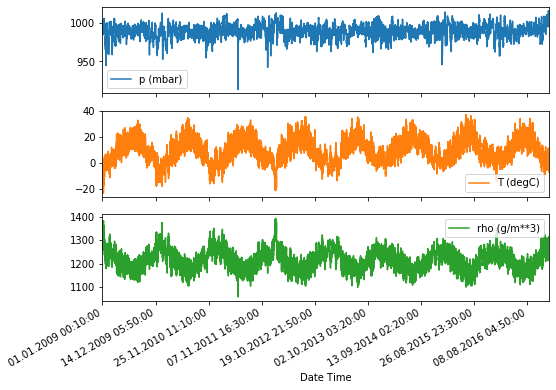

In [72]:
features.plot(subplots=True)

In [73]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [74]:
dataset = (dataset-data_mean)/data_std

In [57]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [77]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, single_step=True)

In [78]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_single[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : ()


In [79]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [80]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [83]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [85]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 27s 136ms/step - loss: 0.3118 - val_loss: 0.2599
Epoch 2/10
200/200 [==============================] - 17s 86ms/step - loss: 0.2624 - val_loss: 0.2507
Epoch 3/10
200/200 [==============================] - 20s 98ms/step - loss: 0.2623 - val_loss: 0.2437
Epoch 4/10
200/200 [==============================] - 21s 105ms/step - loss: 0.2570 - val_loss: 0.2431
Epoch 5/10
200/200 [==============================] - 21s 104ms/step - loss: 0.2286 - val_loss: 0.2369
Epoch 6/10
200/200 [==============================] - 22s 110ms/step - loss: 0.2418 - val_loss: 0.2607
Epoch 7/10
200/200 [==============================] - 21s 104ms/step - loss: 0.2411 - val_loss: 0.2575
Epoch 8/10
200/200 [==============================] - 18s 92ms/step - loss: 0.2404 - val_loss: 0.2459
Epoch 9/10
200/200 [==============================] - 22s 108ms/step - loss: 0.2460 - val_loss: 0.2579
Epoch 10/10
200/200 [============

In [86]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

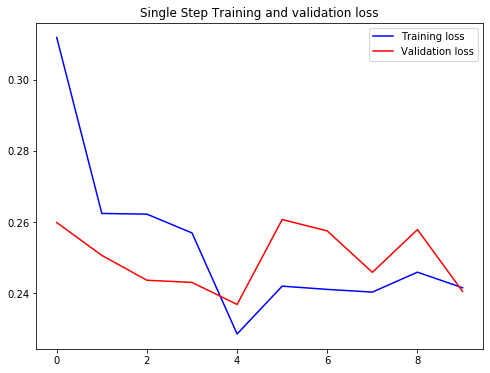

In [87]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [84]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

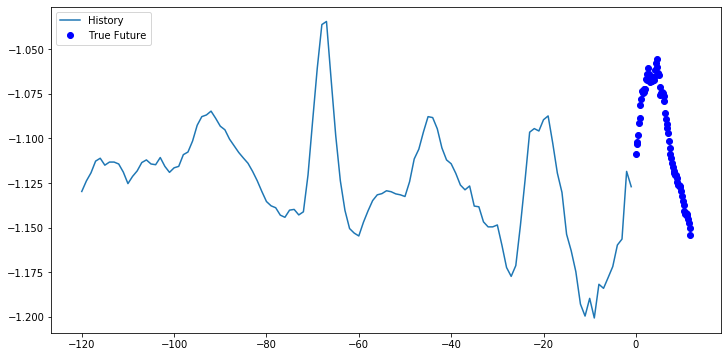

In [69]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [70]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [41]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [42]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 37s 184ms/step - loss: 1.6112 - val_loss: 0.4245
Epoch 2/10
200/200 [==============================] - 33s 167ms/step - loss: 0.5223 - val_loss: 0.3074
Epoch 3/10
200/200 [==============================] - 34s 170ms/step - loss: 0.3718 - val_loss: 0.2745
Epoch 4/10
200/200 [==============================] - 34s 171ms/step - loss: 0.3034 - val_loss: 0.2310
Epoch 5/10
200/200 [==============================] - 34s 172ms/step - loss: 0.2207 - val_loss: 0.2044
Epoch 6/10
200/200 [==============================] - 34s 170ms/step - loss: 0.2189 - val_loss: 0.2068
Epoch 7/10
200/200 [==============================] - 34s 170ms/step - loss: 0.2067 - val_loss: 0.2202
Epoch 8/10
200/200 [==============================] - 35s 176ms/step - loss: 0.2021 - val_loss: 0.2070
Epoch 9/10
200/200 [==============================] - 40s 200ms/step - loss: 0.2049 - val_loss: 0.1925
Epoch 10/10
200/200 [=========

In [44]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

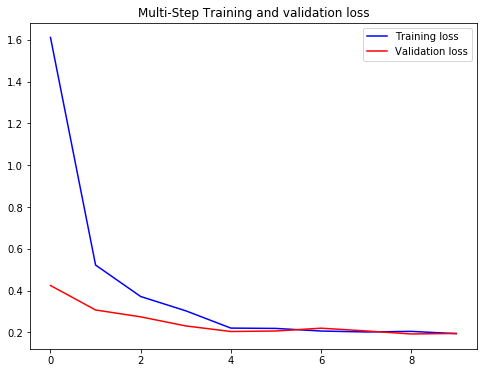

In [45]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

tf.Tensor(
[[[ 0.54748489  0.642228   -0.54922199]
  [ 0.59241221  0.63643877 -0.53307261]
  [ 0.57905544  0.62138676 -0.52157229]
  ...
  [-0.116711    0.64570154 -0.69872616]
  [-0.12399652  0.53454824 -0.59791484]
  [-0.14949581  0.48707652 -0.55607325]]

 [[ 0.54869914  0.63643877 -0.54359418]
  [ 0.5826982   0.63643877 -0.5352748 ]
  [ 0.57905544  0.61907107 -0.51961478]
  ...
  [-0.12278226  0.63643877 -0.69187491]
  [-0.12278226  0.5113913  -0.57613764]
  [-0.15192431  0.47202451 -0.54383886]]

 [[ 0.55841316  0.63643877 -0.5411473 ]
  [ 0.57541268  0.63180738 -0.53282792]
  [ 0.57541268  0.61328183 -0.51472103]
  ...
  [-0.12642502  0.63064953 -0.68624709]
  [-0.12642502  0.4940236  -0.56170106]
  [-0.15071006  0.45349896 -0.52573198]]

 ...

 [[ 0.49041504  0.6445437  -0.56267982]
  [ 0.47341551  0.65264863 -0.57589295]
  [ 0.45641598  0.65149078 -0.57980795]
  ...
  [-0.25392149  1.07642059 -1.14063211]
  [-0.21627968  0.97105653 -1.0415336 ]
  [-0.13978179  0.9259005  -0.980

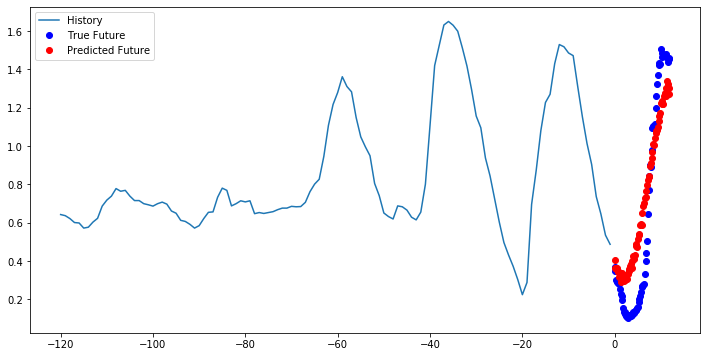

tf.Tensor(
[[[ 0.48798653  0.6445437  -0.56439263]
  [ 0.47341551  0.6445437  -0.56830763]
  [ 0.44427346  0.65264863 -0.58396764]
  ...
  [-0.23813621  0.99884485 -1.07187487]
  [-0.18228062  0.94095251 -1.00213889]
  [-0.10456848  0.89927002 -0.94977572]]

 [[ 0.47584401  0.65149078 -0.57442482]
  [ 0.46248724  0.6445437  -0.57124388]
  [ 0.44791622  0.65380647 -0.58445702]
  ...
  [-0.23449346  0.98495069 -1.05841705]
  [-0.1701381   0.93747897 -0.99577701]
  [-0.10942549  0.90505925 -0.95638229]]

 [[ 0.46734425  0.65264863 -0.57760576]
  [ 0.45763023  0.64801724 -0.57589295]
  [ 0.44305921  0.65264863 -0.58470171]
  ...
  [-0.21992243  0.98263499 -1.05181048]
  [-0.15192431  0.93747897 -0.99284075]
  [-0.10456848  0.89116509 -0.94194572]]

 ...

 [[ 0.15649571  1.62987142 -1.47463079]
  [ 0.13828193  1.62176649 -1.47267329]
  [ 0.12978217  1.52566519 -1.3990223 ]
  ...
  [-0.21870818  0.95484667 -1.00629858]
  [-0.2915633   1.00231839 -1.06282143]
  [-0.35106166  0.89695432 -0.987

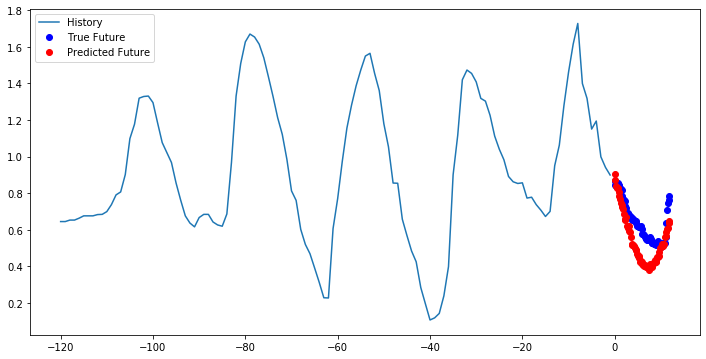

tf.Tensor(
[[[ 0.14435319  1.5974517  -1.44820452]
  [ 0.13463918  1.56503199 -1.42740607]
  [ 0.1212824   1.47356208 -1.35693602]
  ...
  [-0.25027873  0.96989868 -1.02293734]
  [-0.32920512  0.9039014  -0.99063856]
  [-0.37170394  0.92937404 -1.02097984]]

 [[ 0.14435319  1.60324094 -1.4545664 ]
  [ 0.13099642  1.54882213 -1.41590575]
  [ 0.11763965  1.45387869 -1.34029726]
  ...
  [-0.26484976  1.0000027  -1.05474674]
  [-0.33770488  0.87842877 -0.97130824]
  [-0.37048969  0.94905743 -1.03835266]]

 [[ 0.14192469  1.61481941 -1.46557735]
  [ 0.12978217  1.5407172  -1.41052262]
  [ 0.11399689  1.43651098 -1.32537131]
  ...
  [-0.27334952  1.01505471 -1.07016206]
  [-0.3449904   0.88190231 -0.9739998 ]
  [-0.37170394  0.95368882 -1.04275704]]

 ...

 [[-0.12035376  0.84253552 -0.90352975]
  [-0.16163833  1.10420892 -1.11053553]
  [-0.20777991  1.43187959 -1.39926699]
  ...
  [ 0.56448442  0.01814852  0.08770003]
  [ 0.59969773  0.06909378  0.04952876]
  [ 0.67983836  0.28097977 -0.120

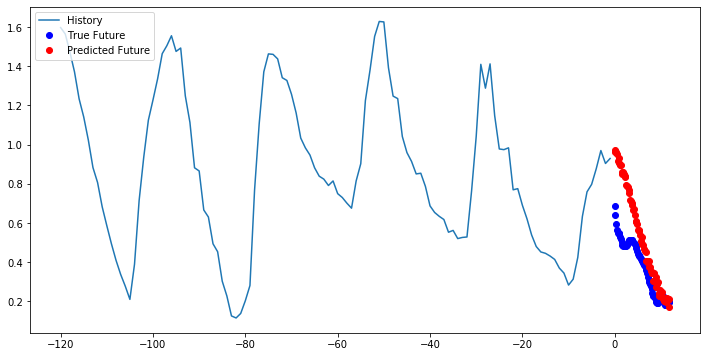

In [47]:
for x, y in val_data_multi.take(3):
    print(x)
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])